In [9]:
import pandas as pd

import torch
import numpy as np
from PIL import Image
from PIL import Image
import os.path
from Cream.TinyViT.models.tiny_vit import tiny_vit_21m_224
from Cream.TinyViT.data import build_transform, imagenet_classnames
from Cream.TinyViT.config import get_config
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from PIL import Image
import pandas as pd
import os
import matplotlib.pyplot as plt

IMAGES_DIR = "../dataset/images/"
ORIGINAL_META_FILE = "../dataset/styles.csv"
META_FILE = "../dataset/cleaned_styles_.csv"
BATCH_SIZE=32

# Data Clean up

## Metadata

In [10]:
metadata = pd.read_csv(ORIGINAL_META_FILE)
metadata.sample(3)

,id,gender,masterCategory,subCategory,articleType,baseColour,season,year,usage,productDisplayName,productUsageRights
31903,55976,Women,Personal Care,Lips,Lipstick,NaN,Summer,2019.0,Casual,Colorbar Velvet Matte Secretly Pink Lipstick 62P,Free
15353,23684,Men,Accessories,Wallets,Wallets,Brown,Fall,2011.0,Casual,Newhide Brown Men Antique Wallet,Free
9928,30494,Women,Apparel,Innerwear,Bra,NaN,Summer,2014.0,Casual,Lovable Women Fiona Brown Bra,Restricted


In [11]:
path = IMAGES_DIR
counter = 0
worng_shape_images = []
missing_files = []
for image_id in metadata.id.items():
    filepath = path + str(image_id[1]) + ".jpg"
    if not os.path.isfile(filepath):
        missing_files.append(image_id[1])
        continue
    img = np.array(Image.open(filepath))
    if img.ndim != 3:
        # print(f"{filename} :: {img.shape}")
        worng_shape_images.append(image_id[1])

print(f"There are {len(metadata)} images in total.")
print(f"There are {len(worng_shape_images)} images with single channel (gray images).")
print(f"There are {len(missing_files)} images that are missed.")

There are 44424 images in total.
There are 431 images with single channel (gray images).
There are 5 images that are missed.


Gray and missing images are just less than %1 metadata so, there is no need to try to fix them and we can ignore them and continue with healthy %99.

In [17]:
metadata = metadata[~metadata["id"].isin(worng_shape_images + missing_files)]
metadata.sample(1000).to_csv(META_FILE)

## possible labels

In [13]:
features = ["gender", "articleType", "baseColour", "season", "usage"]
metadata[features].sample(3)

,gender,articleType,baseColour,season,usage
34469,Women,Bra,Grey,Summer,Casual
10765,Men,Tshirts,Purple,Fall,Casual
20995,Women,Earrings,Gold,Winter,Casual


In [14]:
metadata[features].isna().sum()

gender            0
articleType       0
baseColour     4409
season         4409
usage           316
dtype: int64

I do not see any problem with missing items. They are mainly PersonalCare items and I guess our model can handle it well. Test removing or replacing them later.

In [15]:
metadata = metadata.fillna("missing")

In [8]:
def get_label_map(label_name: str) -> dict:
    return {label_desc: label for label, label_desc in enumerate(metadata[label_name].unique())}
feature_maps = {feature: get_label_map(feature) for feature in features}

In [9]:
feature_maps["season"]

{'Summer': 0, 'missing': 1, 'Fall': 2, 'Winter': 3, 'Spring': 4}

## Loading model

In [10]:
config = get_config()


# Build model
model = tiny_vit_21m_224(pretrained=True)
# model.eval()

## Default Infer

In [11]:
"""Model Inference."""

# Load Image
fname = "../dataset/images/10001.jpg"
image = Image.open(fname)
transform = build_transform(is_train=False, config=config)

# (1, 3, img_size, img_size)
batch = transform(image)[None]

with torch.no_grad():
    logits = model(batch)

# print top-5 classification names
probs = torch.softmax(logits, -1)
scores, inds = probs.topk(5, largest=True, sorted=True)
print('=' * 30)
print(fname)
for score, ind in zip(scores[0].numpy(), inds[0].numpy()):
    print(f'{imagenet_classnames[ind]}: {score:.2f}')

../dataset/images/10001.jpg
toilet seat: 0.01
water bottle: 0.01
toaster: 0.01
trash can: 0.01
mop: 0.01


# Single Class Fine Tune

## Gender Prediciton

### define model

In [12]:
model.head = torch.nn.Linear(model.head.in_features, 3)

### create dataset

In [13]:
# Define the transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images to 224x224
    transforms.ToTensor(),           # Convert PIL image to tensor
])


# Custom dataset class
class CustomImageDataset(Dataset):
    def __init__(self, metadata_file: str, img_dir: str, feature_name: str, feature_maps:dict, transform=None):
        self.metadata = pd.read_csv(metadata_file)
        self.img_dir = img_dir
        self.transform = transform
        self.feature_map = feature_maps[feature_name]
        self.feature_name = feature_name
        
    def __len__(self):
        return len(self.metadata)

    def __getitem__(self, idx):
        image = Image.open(os.path.join(self.img_dir, str(self.metadata.loc[idx, "id"])+".jpg"))
        label = self.feature_map[self.metadata.loc[idx, self.feature_name]]

        if self.transform:
            image = self.transform(image)
        
        return image, label


feature_name = "gender"
# Initialize dataset and dataloader, 
dataset = CustomImageDataset(metadata_file=META_FILE, 
                             img_dir=IMAGES_DIR, 
                             feature_maps = feature_maps,
                             feature_name = feature_name,
                             transform=transform,
                            )

generator = torch.Generator().manual_seed(42)
train_data, val_data, test_data = torch.utils.data.random_split(dataset, [0.7, 0.1, 0.2], generator)

train_dataloader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=True)
val_dataloader = DataLoader(val_data, batch_size=BATCH_SIZE, shuffle=True)

Feature batch shape: torch.Size([32, 3, 224, 224])


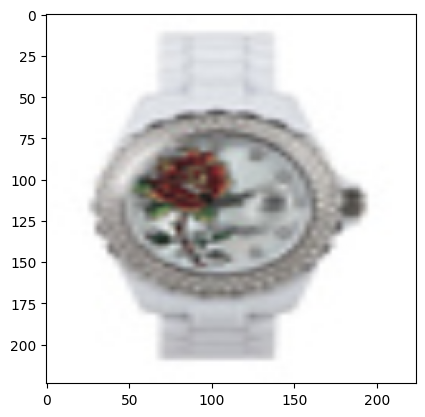

Label: 1


In [14]:


# Display image and label.
features, labels = next(iter(train_dataloader))
print(f"Feature batch shape: {features.size()}")
# print(f"Labels batch shape: {labels.size()}")
img = features[0]#.squeeze()
label = labels[0]
plt.imshow(img.permute(1, 2, 0))
plt.show()
print(f"Label: {label}")

### train

In [15]:
config = get_config()


# Build model
model = tiny_vit_21m_224(pretrained=True)
for param in model.parameters():
    param.requires_grad = False
    
model.head = torch.nn.Linear(model.head.in_features, len(feature_maps[feature_name]))
for param in model.head.parameters():
    param.requires_grad = True
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# model.to(device)

In [17]:
%%time
# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 2

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    
    for it, (inputs, labels) in enumerate(train_dataloader):
        if it == 5:
            break
        # inputs, labels = inputs.to(device), labels.to(device)
        
        # Zero the parameter gradients
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        
        # Backward pass and optimize
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * inputs.size(0)
        print(".", end="")

    epoch_loss = running_loss / len(dataset)
    print(f'\nEpoch {epoch + 1}/{num_epochs}, Loss: {epoch_loss:.4f}')


.....
Epoch 1/2, Loss: 0.0050
.....
Epoch 2/2, Loss: 0.0049
CPU times: user 1min 50s, sys: 18.4 s, total: 2min 8s
Wall time: 26.7 s


In [5]:
from datetime import datetime
datetime.now().strftime("%Y%m%d%H%M")

'202408312232'